In [55]:
import os
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
!pip install gymnasium[mujoco]

In [ ]:
# Function to evaluate keyframes
def evaluate_keyframes(keyframes, render=False, num_runs=3):
    """Simulates Walker2D using keyframes and returns the average reward over multiple runs."""
    env = gym.make("Walker2d-v5", render_mode=None)
    total_rewards = []

    for _ in range(num_runs):
        observation, info = env.reset(seed=42) # Reset environment before each run
        keyframe_index = 0
        remaining_steps = int(keyframes[keyframe_index][-1]) # Extract duration from the first keyframe
        episode_reward = 0

        while True:
            action = keyframes[keyframe_index][:-1]  # Extract the torque values (first 6 values)
            observation, reward, terminated, truncated, info = env.step(action) # Perform action
            episode_reward += reward # Accumulate reward

            if render:
                env.render()

            remaining_steps -= 1
            if remaining_steps == 0: # Move to the next keyframe when current duration expires
                keyframe_index = (keyframe_index + 1) % len(keyframes)
                remaining_steps = keyframes[keyframe_index][-1]

            if terminated or truncated: # Stop simulation if agent falls or reaches time limit
                break

        total_rewards.append(episode_reward) # Store reward for this run

    env.close()
    return np.mean(total_rewards)  # Return the average reward across multiple runs

'''Purpose: Tests a sequence of keyframes and returns the average reward to measure its performance.
How It Helps: Ensures that the best keyframes consistently perform well by averaging over multiple runs.
Why Multiple Runs? The environment can be stochastic, so averaging helps reduce noise.'''

In [ ]:
def generate_random_keyframes(K):
    return [np.append(np.random.uniform(-1, 1, 6), np.random.randint(5, 50)) for _ in range(K)]

'''Purpose: Creates a random set of keyframes where:
The first 6 values represent torques applied to joints (range: -1 to 1).
The last value represents the duration of that keyframe (range: 5 to 50 steps).
How It Helps: Provides a diverse initial population to improve the chances of finding an optimal solution.'''

def initialize_population(pop_size, K):
    return [generate_random_keyframes(K) for _ in range(pop_size)]

'''Purpose: Generates an initial population of size pop_size, each with K keyframes.
How It Helps: Creates a starting diversity in the genetic algorithm.'''

In [ ]:
# Selection Methods
def tournament_selection(population, fitness_scores, k=3):
    """Selects a parent using tournament selection."""
    selected = random.sample(list(zip(population, fitness_scores)), k) # Randomly select k individuals
    return max(selected, key=lambda x: x[1])[0]   # Return the best one based on fitness score

"""Purpose: Selects the best individual from a randomly chosen subset of k candidates.
How It Helps: Ensures stronger candidates are more likely to be selected, improving optimization speed."""

def roulette_wheel_selection(population, fitness_scores):
    """Selects a parent using roulette wheel selection."""
    fitness_scores = np.array(fitness_scores) - np.min(fitness_scores) + 1e-6  # Normalize to avoid negative values
    selection_probs = fitness_scores / np.sum(fitness_scores) # Convert scores to probabilities
    return population[np.random.choice(len(population), p=selection_probs)] # Pick a parent based on probability

"""Purpose: Assigns selection probability proportional to fitness.
How It Helps: Higher fitness individuals are more likely to be chosen but low fitness ones still have a chance."""

def rank_selection(population, fitness_scores):
    """Selects a parent using rank-based selection."""
    sorted_pop = [x for _, x in sorted(zip(fitness_scores, population))] # Rank population by fitness
    rank_probs = np.linspace(0, 1, len(sorted_pop)) # Assign increasing probabilities
    rank_probs /= np.sum(rank_probs)  # Normalize probabilities
    return sorted_pop[np.random.choice(len(sorted_pop), p=rank_probs)] # Select parent

"""Purpose: Reduces bias by assigning linearly increasing probabilities instead of fitness-based ones.
How It Helps: Avoids dominance of high fitness individuals too early."""


In [ ]:
def crossover(parent1, parent2):
    """Performs uniform crossover for each keyframe between two parents."""
    child = []
    for kf1, kf2 in zip(parent1, parent2):
        mask = np.random.rand(len(kf1)) < 0.5  # Create a random binary mask
        child_kf = np.where(mask, kf1, kf2)  # Take values from parent1 if mask=1, else from parent2
        child.append(child_kf)
    return child

"""Purpose: Creates a new child keyframe by randomly mixing 50% of genes from each parent.
How It Helps: Introduces genetic diversity while preserving good traits."""

# Mutation
def mutate(keyframes, mutation_rate=0.1):
    """Mutates keyframes by applying small Gaussian noise."""
    for keyframe in keyframes:
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.randint(6)  # Select parameter to mutate
            keyframe[mutation_index] += np.random.normal(0, 0.1)  # Apply small noise
    return keyframes

"""Purpose: Introduces random variations to avoid getting stuck in local optima.
How It Helps: Encourages exploration of new solutions."""

In [ ]:
def evolutionary_optimization(pop_size, generations, mutation_rate, crossover_rate, keyframe_count, tournament_size, step_limit, elite_count, stagnation_limit, selection_strategy):
    population = initialize_population(pop_size, keyframe_count)
    best_fitness_over_generations = []

    for generation in range(generations):
        fitness_scores = [evaluate_keyframes(ind) for ind in population]

        best_fitness = max(fitness_scores)
        best_fitness_over_generations.append(best_fitness)
        print(f"Generation {generation}: Best Reward = {best_fitness}")

        new_population = []
        for _ in range(pop_size // 2):
            if selection_strategy == "tournament": # Iterate half the population size (each pair produces 2 children)
                parent1 = tournament_selection(population, fitness_scores, tournament_size) # Select parent using tournament selection
                parent2 = tournament_selection(population, fitness_scores, tournament_size)
            elif selection_strategy == "roulette":
                parent1 = roulette_wheel_selection(population, fitness_scores) # Select parent using roulette selection
                parent2 = roulette_wheel_selection(population, fitness_scores)
            elif selection_strategy == "rank":
                parent1 = rank_selection(population, fitness_scores) # Select parent using rank selection
                parent2 = rank_selection(population, fitness_scores)
            else:
                raise ValueError("Invalid selection strategy")

            if np.random.rand() < crossover_rate:
                child1 = mutate(crossover(parent1, parent2), mutation_rate) # Create child1 by crossing parent1 & parent2, then mutating
                child2 = mutate(crossover(parent2, parent1), mutation_rate) # Create child1 by crossing parent1 & parent2, then mutating
            else:
                child1, child2 = parent1, parent2

            new_population.extend([child1, child2])

        population = new_population # Replace old population

    best_solution = population[np.argmax(fitness_scores)]
    return best_solution, best_fitness_over_generations

'''evolutionary_optimization:

Initializes the population.
Evaluates fitness for each individual.
Selects parents using the chosen strategy (tournament, roulette, or rank).
Applies crossover & mutation to create new offspring.
Repeats for multiple generations.
How It Helps: Evolves better keyframe sequences over time.

Selection:

We iterate half the population size (pop_size // 2) because each parent pair produces two children.
Parents are selected based on the specified selection strategy:
Tournament Selection: Picks the best among k random candidates.
Roulette Wheel Selection: Assigns probability based on fitness.
Rank Selection: Assigns increasing probabilities based on rank.
Crossover & Mutation:

The parents undergo crossover (gene mixing) to create children.
The children then undergo mutation to introduce random variations.
This helps maintain genetic diversity and prevent getting stuck in local optima.
Adding to the Next Generation:

The newly created children are added to new_population, forming the next generation.'''


Generation 0: Best Reward = 47.91413449364048
Generation 1: Best Reward = 141.50606102524748
Generation 2: Best Reward = 208.74507172238722
Generation 3: Best Reward = 236.82962569323084
Generation 4: Best Reward = 324.1245946606901
Generation 5: Best Reward = 364.8109152652034
Generation 6: Best Reward = 365.82254189254286
Generation 7: Best Reward = 399.2110085035826
Generation 8: Best Reward = 434.5301217249989
Generation 9: Best Reward = 438.56151852411057
Generation 10: Best Reward = 448.0665102580492
Generation 11: Best Reward = 464.58597863907033
Generation 12: Best Reward = 472.1503805606838
Generation 13: Best Reward = 486.3403411081324
Generation 14: Best Reward = 488.68196776047006
Generation 15: Best Reward = 492.1261594125611
Generation 16: Best Reward = 493.56196954614353
Generation 17: Best Reward = 493.56196954614353
Generation 18: Best Reward = 495.43205961168786
Generation 19: Best Reward = 499.2265989519505
Generation 20: Best Reward = 514.5917269362736
Generation 21

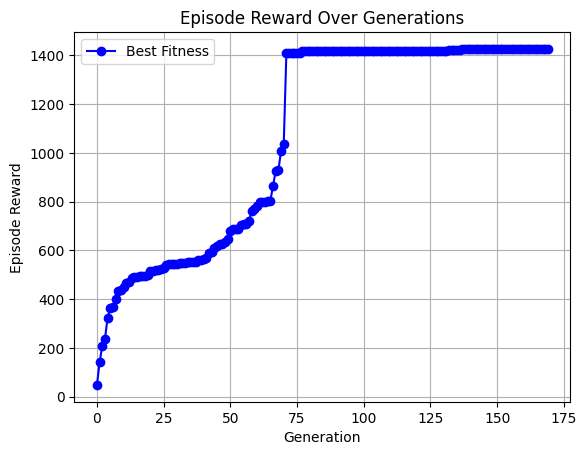

In [61]:
def main():
    best_keyframes, fitness_over_generations = evolutionary_optimization(
        pop_size=150,
        generations=170,
        mutation_rate=0.125,
        crossover_rate=0.9,
        keyframe_count=6,
        tournament_size=12,
        step_limit=6000,
        elite_count=50,
        stagnation_limit=50,
        selection_strategy="tournament"
    )

    print("\nBest keyframes obtained:", best_keyframes)

    num_tests = 5
    test_rewards = [evaluate_keyframes(best_keyframes) for _ in range(num_tests)]
    avg_reward = np.mean(test_rewards)
    print(f"Final Reward of Best Solution (Average over {num_tests} runs): {avg_reward}")

    with open("best_keyframes.txt", "w") as f:
        f.write(f"{len(best_keyframes)}\n")
        for keyframe in best_keyframes:
            f.write(", ".join(map(str, keyframe)) + "\n")

    plt.plot(fitness_over_generations, label="Best Fitness", color="blue", linestyle="-", marker="o")
    plt.xlabel("Generation")
    plt.ylabel("Episode Reward")
    plt.title("Episode Reward Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

main()
